### Editing state once graph is stopped at a state and human feedback

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

GOOGLE_API_KEY = os.environ.get('GOOGLE_API_KEY')

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash', temperature=1.0, google_api_key = GOOGLE_API_KEY)

/opt/anaconda3/envs/langchainAcademy/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
def multiply(a,b):
    ''' Multiple two numbers
    Agrs
    a: first int
    b: second int
    '''
    return a*b

def divide(a, b):
    ''' Divide two numbers
    Args
    a: first int
    b: second int
    '''
    return a/b

def add(a,b):
    ''' Add two numbers
    Args
    a: first int
    b: second int
    '''
    return a+b

tools = [multiply, add, divide]
llm_with_tools = llm.bind_tools(tools)

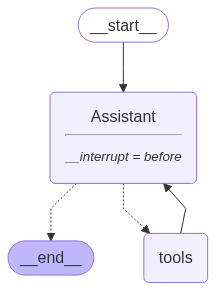

In [5]:
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage
from langchain_core.messages import HumanMessage, AnyMessage, RemoveMessage

class MessagesState(TypedDict):
    messages: Annotated[list[str], add_messages]
    
sys_message = SystemMessage(content = 'You are a helpful assistant tasked with performing arithmetic on a set of inputs')

def llm_call(state: MessagesState):
    return {'messages': [llm_with_tools.invoke([sys_message] +state['messages'])]}
    
builder = StateGraph(MessagesState)
builder.add_node('Assistant', llm_call)
builder.add_node('tools', ToolNode(tools))

# LOGIC
builder.add_edge(START, 'Assistant')
builder.add_conditional_edges('Assistant', tools_condition)
builder.add_edge('tools', 'Assistant')

memory = MemorySaver()

graph = builder.compile(interrupt_before = ['Assistant'], checkpointer = memory)
graph

In [7]:
initial_input = {'messages': [HumanMessage(content = 'Multiply 2 and 6')]}
thread = {'configurable': {'thread_id': 1}}
for event in graph.stream(initial_input, thread, stream_mode = 'values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 6


In [11]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 6', additional_kwargs={}, response_metadata={}, id='df47f8d7-b189-4636-b3d6-8ea45e5fb523')]}, next=('Assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04662d-b90b-67be-8000-5c6e4cdc8400'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': 1}, created_at='2025-06-11T01:24:45.291919+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04662d-b908-6b90-bfff-1695e6c55c71'}}, tasks=(PregelTask(id='d84a18dc-a5bd-db82-4099-387896f15aa8', name='Assistant', path=('__pregel_pull', 'Assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [12]:
graph.update_state(
    thread,
    {'messages': HumanMessage('No, actually multiply 3 and 3')}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f046634-549d-6e7e-8001-acefaa5b2bd0'}}

In [13]:
new_state = graph.get_state(thread)
new_state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 6', additional_kwargs={}, response_metadata={}, id='df47f8d7-b189-4636-b3d6-8ea45e5fb523'), HumanMessage(content='No, actually multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='62d97074-6d1b-465f-b3b2-63a22b571b69')]}, next=('Assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f046634-549d-6e7e-8001-acefaa5b2bd0'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': HumanMessage(content='No, actually multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='62d97074-6d1b-465f-b3b2-63a22b571b69')}}, 'step': 1, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-11T01:27:42.666077+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04662d-b90b-67be-8000-5c6e4cdc8400'}}, tasks=(PregelTask(id='b03464a5-c567-8018-a0a5-8d3858864714', name='Assistant', path=('__pregel_pull', 'Assistant'),

In [14]:
for event in graph.stream(None, thread, stream_mode = 'values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (72d78722-4fd5-4459-9873-8dac3a7f112e)
 Call ID: 72d78722-4fd5-4459-9873-8dac3a7f112e
  Args:
    a: 3.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

9.0


In [15]:
for event in graph.stream(None, thread, stream_mode = 'values'):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9.0
================================== Ai Message ==================================

OK. The result of multiplying 3 and 3 is 9.


### Getting user input to modify a state

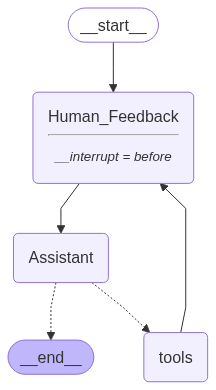

In [4]:
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage
from langchain_core.messages import HumanMessage, AnyMessage, RemoveMessage

class MessagesState(TypedDict):
    messages: Annotated[list[str], add_messages]

sys_message = SystemMessage(content = 'You are a helpful assistant tasked with performing arithmetic on a set of inputs')

# this will accept user feedback and inject it to the graph at a particular point
def human_feedback(state: MessagesState):
    pass

def assistant(state: MessagesState):
    return {'messages': [llm_with_tools.invoke([sys_message] + state['messages'])]}

builder = StateGraph(MessagesState)

builder.add_node('Assistant', assistant)
builder.add_node('tools', ToolNode(tools))
builder.add_node('Human_Feedback', human_feedback)

# LOGIC
builder.add_edge(START, 'Human_Feedback')
builder.add_edge('Human_Feedback', 'Assistant')
builder.add_conditional_edges('Assistant', tools_condition)
builder.add_edge('tools', 'Human_Feedback')

memory = MemorySaver()
graph = builder.compile(checkpointer = memory, interrupt_before = ['Human_Feedback'])

graph

In [5]:
initial_input = {'messages': 'Add 2 and 8'}

thread = {'configurable': {'thread_id': 10}}

for event in graph.stream(initial_input, thread, stream_mode = 'values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Add 2 and 8


In [6]:
user_input = input('Tell me how you want to update the state')

Tell me how you want to update the state No, divide 10 by 2


In [7]:
print(user_input)
graph.update_state(
    thread,
    {'messages': [HumanMessage(content= user_input)]}, 
     as_node = 'Human_Feedback'
)

No, divide 10 by 2


{'configurable': {'thread_id': '10',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0466dd-25ab-613a-8001-782df18ec868'}}

In [8]:
for event in graph.stream(None, thread, stream_mode = 'values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, divide 10 by 2
================================== Ai Message ==================================
Tool Calls:
  divide (454ce073-f6f4-4604-b8e8-938f81832665)
 Call ID: 454ce073-f6f4-4604-b8e8-938f81832665
  Args:
    b: 2.0
    a: 10.0
================================= Tool Message =================================
Name: divide

5.0


In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: divide

5.0
================================== Ai Message ==================================

I have divided 10 by 2, and the answer is 5.


In [8]:
input_message = {'messages': 'multiple 2 and 2'}
thread = {'configurable': {'thread_id': 1}}

for event in graph.stream(input_message, thread, stream_mode = 'values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiple 2 and 2


In [11]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='multiple 2 and 2', additional_kwargs={}, response_metadata={}, id='54218850-0d5a-4492-8535-4783f37ad65e')]}, next=('Human_Feedback',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0466c8-c626-60de-8001-9d7b6f6010d8'}}, metadata={'source': 'loop', 'writes': None, 'step': 1, 'parents': {}, 'thread_id': 1}, created_at='2025-06-11T02:34:07.415507+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0466c8-c61a-6040-8000-e94968d747e2'}}, tasks=(PregelTask(id='b28a6175-117a-0261-352e-5a861423f02b', name='Human_Feedback', path=('__pregel_pull', 'Human_Feedback'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [12]:
for event in graph.stream(None, thread, stream_mode = 'values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiple 2 and 2


In [13]:
graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='multiple 2 and 2', additional_kwargs={}, response_metadata={}, id='54218850-0d5a-4492-8535-4783f37ad65e')]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0466cb-4747-6918-8003-15c56cac0f51'}}, metadata={'source': 'loop', 'writes': {'Assistant': None}, 'step': 3, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-11T02:35:14.642943+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0466cb-3fb8-6328-8002-94a289d440c3'}}, tasks=(), interrupts=())